# Setup

### Connecting with Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


you can download dataset from [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus#ner_dataset.csv)

In [ ]:
import os

os.chdir("/content/drive/MyDrive/Intro to RC")
print(os.getcwd())
print(os.listdir('.'))

/content/drive/MyDrive/Intro to RC
['correctedfulltrain.csv', 'all_recipe_text.txt', 'prelim_markup.py', 'bert_huggingface_training.ipynb']


### Create Dataframe from CSV

In [ ]:
import pandas as pd
# creating a data frame from CSV rather than google drive
data = pd.read_csv("correctedfulltrain.csv", encoding = 'unicode_escape', engine ='python', on_bad_lines='skip')

#print to test load of dataframe
print(data.head(5))


    Sentence #   Word     Tag
0  Sentence: 1    106       O
1  Sentence: 2   CORN       O
2  Sentence: 2  BREAD       O
3  Sentence: 2    1/2   B-qty
4  Sentence: 2    cup  B-unit


# Code

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[25]

['Place',
 'part',
 'of',
 'the',
 'asparagus',
 'in',
 'baking',
 'dish',
 'then',
 'layer',
 'of',
 'eggs',
 'then',
 'cheese',
 '.']

In [ ]:
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[10])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'B-qty', 'B-cont', 'I-cont', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

### BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.9 MB/s 
     |████████████████████████████████| 182 kB 63.5 MB/s 
     |████████████████████████████████| 7.6 MB 65.2 MB/s 


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.13.0+cu116'

In [ ]:
MAX_LEN = 75 # Sentcen Max length
bs = 32 # Batch Size

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla T4'

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
###CREATE TOKENIZER- not in colab script
# Initialize an empty BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_texts_and_labels = list()

for sent, labs in zip(sentences, labels):
  tokenized_texts_and_labels.append(tokenize_and_preserve_labels(sent, labs))

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
print(tokenized_texts[10])
print(labels[10])

['mrs', '.', 'a', '.', 'e', '.', 'lancaster', 'stuffed', 'bell', 'pepper', '1', 'cup', 'cooked', 'rice', '1', 'can', 'italian', 'gr', '##av', '##y', '1', '/', '2', 'cup', 'gr', '##ated', 'cheese', '1', 'cup', 'pot', '##ted', 'meat', '6', 'bell', 'peppers', '(', 'sc', '##ald', '##ed', 'to', 'remove', 'skin', ')', 'mix', 'rice', 'italian', 'gr', '##av', '##y', 'and', 'pot', '##ted', 'meat', '-', 'stuff', 'peppers', '-', 'top', 'with', 'cheese', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'B-qty', 'B-unit', 'B-ing', 'I-ing', 'I-ing', 'I-ing', 'B-qty', 'B-qty', 'B-qty', 'B-unit', 'B-ing', 'B-ing', 'I-ing', 'B-qty', 'B-unit', 'B-ing', 'B-ing', 'I-ing', 'B-qty', 'B-cont', 'I-cont', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

### Setup the Bert model for finetuning

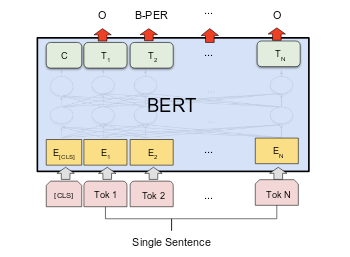

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-cased model and provide the number of possible labels.

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.25.1'

In [ ]:
len(tag2idx)

19

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

#epochs was 3, setting to 1 for debugging
epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Finetune Bert

First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You ca find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=889ee7d31cfd6c44910afcc2a24b26440b966f93344a073153d554dd1c3c8f5d
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

#defining these so they don't pass out of scope once training is done
pred_tags =[]
valid_tags = []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    #fixed eval metrics
    print("Validation F1-Score: ")
    print(f1_score([pred_tags],[valid_tags]))
    print("Validation Precision: ")
    print(precision_score([pred_tags], [valid_tags]))
    print("Validation Recall: ")
    print(recall_score([pred_tags], [valid_tags]))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.23231335115014462


Epoch:  10%|█         | 1/10 [01:14<11:11, 74.57s/it]

Validation loss: 0.031609097005505314
Validation Accuracy: 0.9914473684210525
Validation F1-Score: 
0.883340327318506
Validation Precision: 
0.8863157894736842
Validation Recall: 
0.8803847762442493
Average train loss: 0.034662537543615056


Epoch:  20%|██        | 2/10 [02:29<09:59, 74.99s/it]

Validation loss: 0.018169422584928964
Validation Accuracy: 0.9955043859649123
Validation F1-Score: 
0.9413988657844992
Validation Precision: 
0.9435789473684211
Validation Recall: 
0.9392288348700755
Average train loss: 0.020411770179464717


/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  30%|███       | 3/10 [03:45<08:46, 75.22s/it]

Validation loss: 0.016178886007860695
Validation Accuracy: 0.9961184210526316
Validation F1-Score: 
0.9523610530714585
Validation Precision: 
0.9595789473684211
Validation Recall: 
0.9452509332227291
Average train loss: 0.014183557236959276


Epoch:  40%|████      | 4/10 [05:00<07:32, 75.37s/it]

Validation loss: 0.014363393815552914
Validation Accuracy: 0.9966228070175439
Validation F1-Score: 
0.9613752122241087
Validation Precision: 
0.9536842105263158
Validation Recall: 
0.9691912708600771
Average train loss: 0.01107137356762235


Epoch:  50%|█████     | 5/10 [06:16<06:17, 75.44s/it]

Validation loss: 0.01393744120325305
Validation Accuracy: 0.9966447368421051
Validation F1-Score: 
0.962962962962963
Validation Precision: 
0.9578947368421052
Validation Recall: 
0.9680851063829787
Average train loss: 0.009134507171975786


Epoch:  60%|██████    | 6/10 [07:32<05:01, 75.50s/it]

Validation loss: 0.015276248585187682
Validation Accuracy: 0.996842105263158
Validation F1-Score: 
0.9644067796610171
Validation Precision: 
0.9583157894736842
Validation Recall: 
0.9705756929637527
Average train loss: 0.007282636934082563


Epoch:  70%|███████   | 7/10 [08:47<03:46, 75.51s/it]

Validation loss: 0.015136985845042784
Validation Accuracy: 0.9967324561403509
Validation F1-Score: 
0.965241204971561
Validation Precision: 
0.9646315789473684
Validation Recall: 
0.9658516020236088
Average train loss: 0.006356390603281536


Epoch:  80%|████████  | 8/10 [10:03<02:31, 75.54s/it]

Validation loss: 0.014782611536487055
Validation Accuracy: 0.997017543859649
Validation F1-Score: 
0.9678782755705831
Validation Precision: 
0.9642105263157895
Validation Recall: 
0.9715740347899873
Average train loss: 0.005852551289019856


Epoch:  90%|█████████ | 9/10 [11:18<01:15, 75.57s/it]

Validation loss: 0.015310589513606638
Validation Accuracy: 0.9969298245614034
Validation F1-Score: 
0.966680725432307
Validation Precision: 
0.9650526315789474
Validation Recall: 
0.9683143219264893
Average train loss: 0.0051124334272013554


Epoch: 100%|██████████| 10/10 [12:34<00:00, 75.44s/it]

Validation loss: 0.015368858646405371
Validation Accuracy: 0.9969736842105261
Validation F1-Score: 
0.9676874340021119
Validation Precision: 
0.9646315789473684
Validation Recall: 
0.9707627118644068


In [ ]:
    print("Validation F1-Score: ")
    print(f1_score([pred_tags],[valid_tags]))
    print("Validation Precision: ")
    print(precision_score([pred_tags], [valid_tags]))
    print("Validation Recall: ")
    print(recall_score([pred_tags], [valid_tags]))

Validation F1-Score: 
0.9676874340021119
Validation Precision: 
0.9646315789473684
Validation Recall: 
0.9707627118644068


## Visualize the training loss

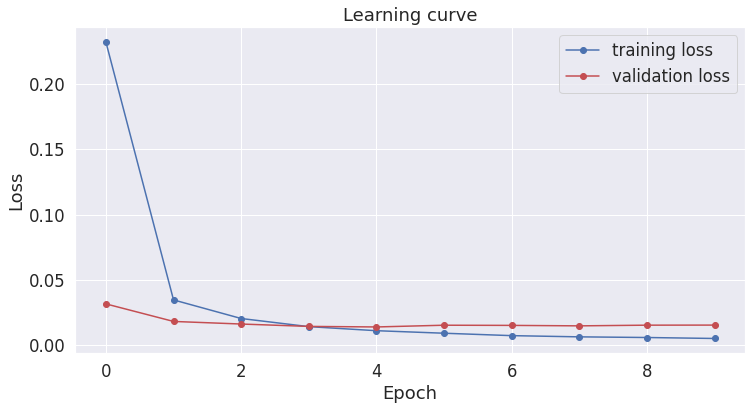

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#Pickle resulting model for use later


In [ ]:
import pickle
import torch

picklepath = "/content/drive/MyDrive/Intro to RC/"
torch.save(model, 'foodbert.model')

pickle_out = open(picklepath+"tag_values.pickle", "wb")
pickle.dump(tag_values, pickle_out)
pickle_out.close()
print("Model saved!")

Model saved!


## Apply the model to new sentence

In [ ]:
test_sentence = """
Apple Cobbler 1 1/2 cups apples chopped 2 tablespoons sugar 3 cups flour 2 pears salt and pepper
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-ing	[CLS]
B-ing	apple
I-ing	cobbler
B-qty	1
I-qty	1
I-qty	/
I-qty	2
B-unit	cups
B-ing	apples
O	chopped
B-qty	2
B-unit	tablespoons
B-ing	sugar
B-qty	3
B-unit	cups
B-ing	flour
B-qty	2
B-cont	pears
B-nqt	salt
B-func	and
B-nqt	pepper
O	[SEP]
